<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/machine_learning/Random_forest_Modular_Daily_For_indiavix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [2]:
!pwd

/content


In [3]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 10.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=82b272694a72f3744984535d927dfbf65621449d9d3debb4b25e8942d49de677
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
matplotlib.style.use('fivethirtyeight')

In [6]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [7]:
#tickr ='maruti.ns'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

In [8]:
df_old = pd.DataFrame()

In [9]:
data= pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/vix.csv')

In [10]:
data=data.set_index('Date')

In [11]:
#df_old = yf.download(tickr,'2009-01-01','2018-05-01')

In [12]:
data.tail(2)

,Open,High,Low,Close
Date,,,,
05-10-2021,16.73,17.13,16.29,16.39
06-10-2021,16.39,17.59,16.10,17.33


In [13]:
df_old=data[:'08-01-2019']

In [14]:
#df_old=df_old.reset_index()

# INPUT

In [15]:
# INPUT .........

#  ********************************* #

t=2
days_out=7


#  ********************************* #

In [16]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [17]:
def get_indicators(data ,days_out,t=1,Vol=True):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    #data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    if Vol==True:
      #data=ta.exponential_moving_average(data , 13*t)
      #data=ta.exponential_moving_average(data ,26*t)
      data=ta.force_index(data ,days_out)
      data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [18]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [19]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [20]:
df_old.tail(2)

,Open,High,Low,Close
Date,,,,
07-01-2019,16.1625,16.4550,15.3025,16.3025
08-01-2019,16.3025,16.5725,14.7350,15.7000


In [21]:
df_train.shape , df_test.shape

((1036, 4), (296, 4))

In [22]:
df_train = get_indicators(df_train,days_out,1,Vol=False)
df_test= get_indicators(df_test,days_out,1,Vol=False)

In [23]:
df_train.shape

(1036, 26)

In [24]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()


In [25]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [26]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [27]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [28]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [29]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [30]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  100.0


Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


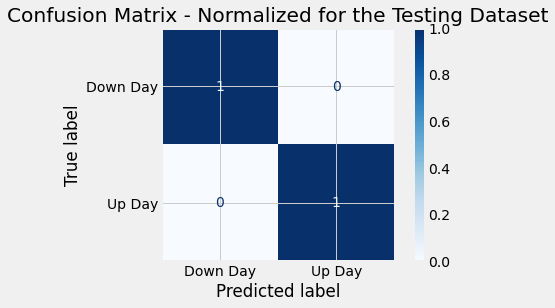

In [31]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [32]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [33]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [34]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [35]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  96.028880866426


Accuracy: 96.028880866426
Percision: 95.33333333333334
Recall: 97.27891156462584
Specificity: 94.61538461538461


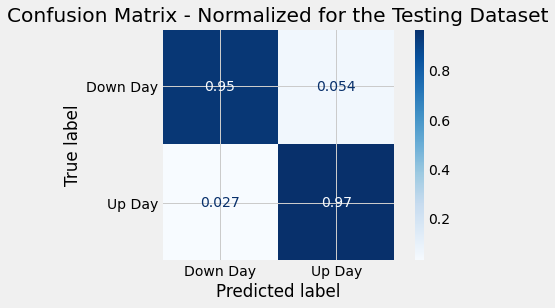

In [36]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [37]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [38]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  95.30685920577618


Accuracy: 95.30685920577618
Percision: 92.94871794871796
Recall: 98.63945578231292
Specificity: 91.53846153846153


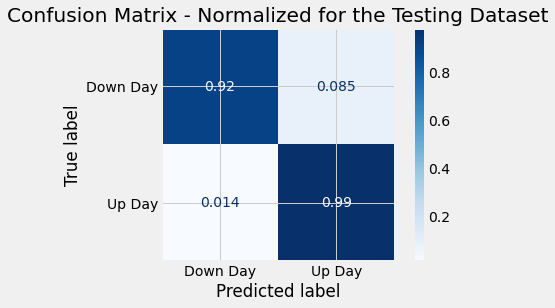

In [39]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [40]:
import xgboost as xgb

In [41]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [42]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 100.00


Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


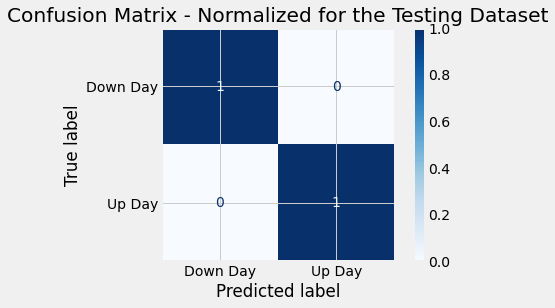

In [43]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [44]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Momentum_7                  60.657990
ROC_7                       14.913252
Vortex_7                     5.520838
PP                           1.972338
MACDdiff_9_12                1.947151
SO%k                         1.919211
MACD_9_12                    1.543481
EMA_7                        1.526382
Open                         1.439801
RSI_7                        1.028048
S3                           0.727666
Win_Low                      0.726908
S1                           0.710549
R2                           0.702697
R3                           0.623208
High                         0.608244
Low                          0.543520
SO%d_7                       0.540673
STD_7                        0.527456
Win_High                     0.527094
Trix_7                       0.498330
MACDsign_9_12                0.493046
S2                           0.152578
Close                        0.149545
R1                           0.000000
Signals_from_Window_HiLo     0.000000
dtype: float

In [45]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [46]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Momentum_7,0.485871,0.606580
ROC_7,0.173817,0.149133
Vortex_7,0.105299,0.055208
PP,0.004091,0.019723
MACDdiff_9_12,0.075139,0.019472
SO%k,0.008403,0.019192
MACD_9_12,0.037200,0.015435
EMA_7,0.002892,0.015264
Open,0.002183,0.014398
RSI_7,0.030714,0.010280


# Make Actual Prediction

In [47]:
df = pd.DataFrame()
df=data['01-10-2019':]

In [48]:
#df = yf.download(tickr,'2019-01-01')

In [49]:
df.tail(3)

,Open,High,Low,Close
Date,,,,
04-10-2021,17.21,17.53,15.31,16.73
05-10-2021,16.73,17.13,16.29,16.39
06-10-2021,16.39,17.59,16.10,17.33


# Check This For Weekly or Daily

In [50]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [51]:
df = get_indicators(df,days_out,1,Vol=False)
#df= impulse(df)

In [52]:
df.tail(2)

,Open,High,Low,Close,RSI_7,Momentum_7,ROC_7,EMA_7,STD_7,SO%d_7,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_7,Vortex_7,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
05-10-2021,16.73,17.13,16.29,16.39,0.287510,-0.532501,-0.092093,17.149928,0.947034,0.511406,0.119048,0.174226,0.281171,-0.106945,16.603333,16.916667,16.076667,17.443333,15.763333,17.756667,15.236667,0.010665,0.188254,19.434999,12.7725,0.0
06-10-2021,16.39,17.59,16.10,17.33,0.428453,-0.722500,-0.065012,17.194946,0.945762,0.589931,0.825503,0.158306,0.256598,-0.098292,17.006667,17.913333,16.423333,18.496667,15.516667,19.403333,14.933333,0.008227,0.140614,19.434999,13.5150,0.0


In [53]:
#df.tail(2)
#if os.path.exists('/content/indiavix.csv'):
#  del df['index']

In [54]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

In [55]:
df=df.dropna()

In [56]:
[cols for cols in df.columns.tolist() if cols not in df_train.columns.tolist()]

[]

In [57]:
test=df.columns.tolist()
train=df_train.columns.tolist()
[i for i in train if i not in test]

[]

In [58]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [59]:
model='random_forest'

In [60]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [61]:
print("days_out : ",days_out)

days_out :  7


In [62]:
preds.head(2)

,predsrandom_forest
Date,
31-10-2019,-1.0
01-11-2019,-1.0


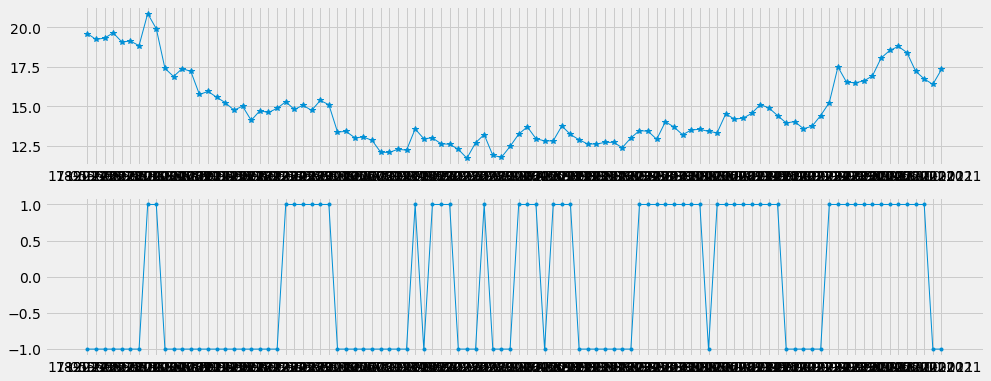

In [63]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [64]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [65]:
pred.head(2)

,predsrandom_forest
Date,
31-10-2019,-1.0
01-11-2019,-1.0


In [66]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [67]:
l= len(pred)

In [68]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [69]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [70]:
model='_XGB'

In [71]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [72]:
predX= pd.concat([predX ,df.Close],axis=1)

In [73]:
predX.head(2)

,preds_XGB,Close
Date,,
31-10-2019,-1.0,16.280001
01-11-2019,-1.0,15.732500


In [74]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

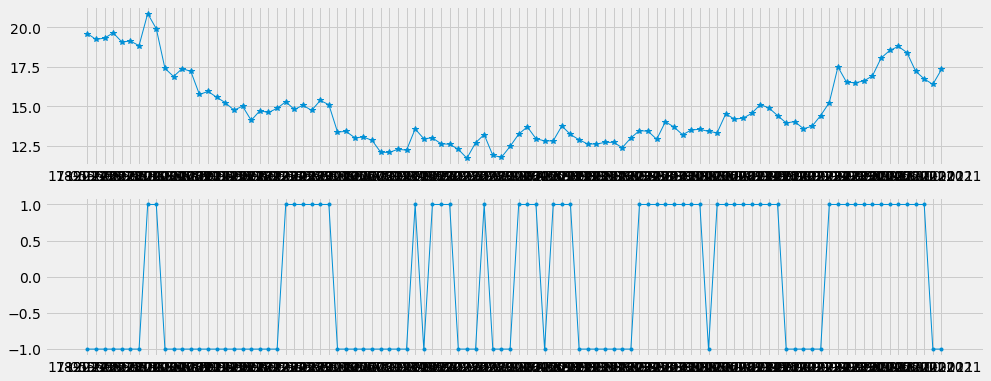

In [75]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [76]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [77]:
model='_Logistic_Regression'

In [78]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [79]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
31-10-2019,-1.0
01-11-2019,-1.0


In [80]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [81]:
predL=predL.reset_index()

In [82]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

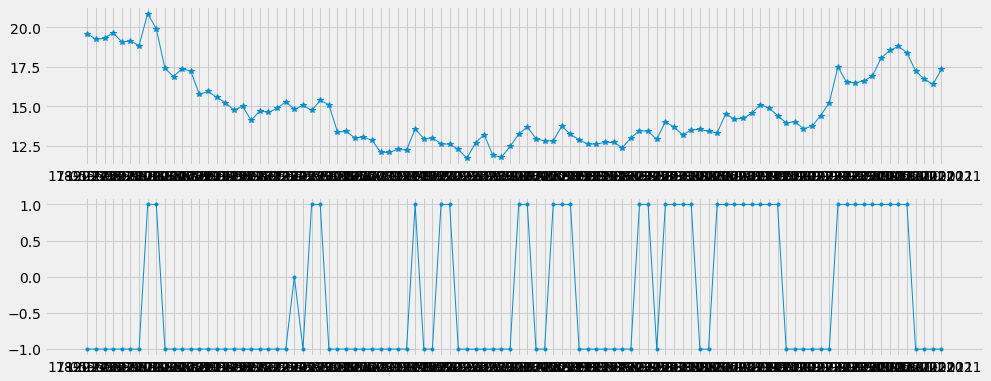

In [83]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [84]:
model='_SVC'

In [85]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [86]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [87]:
predS=predS.reset_index()

In [88]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

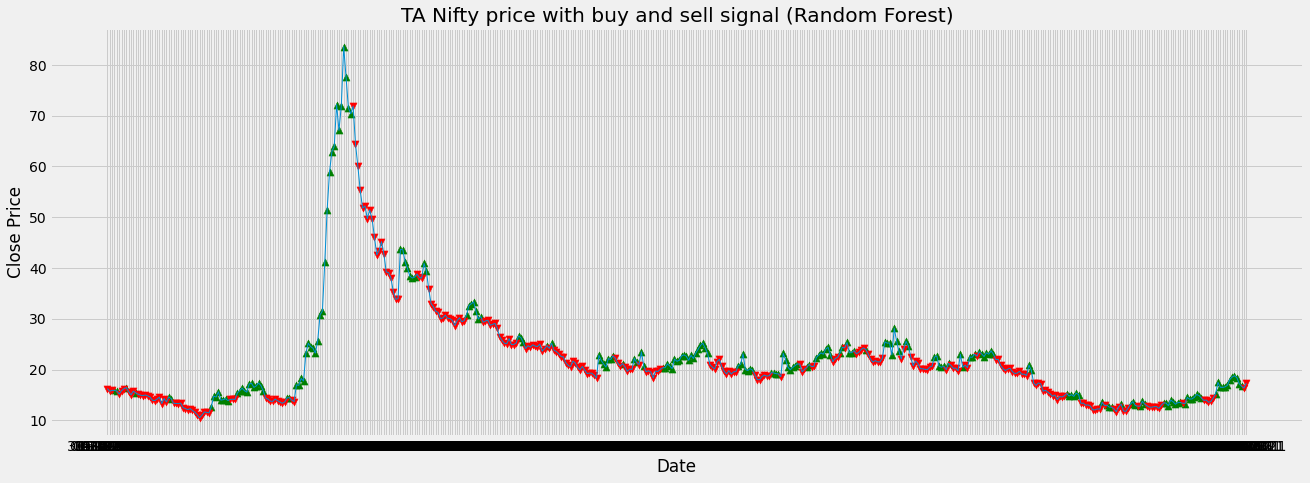

In [89]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

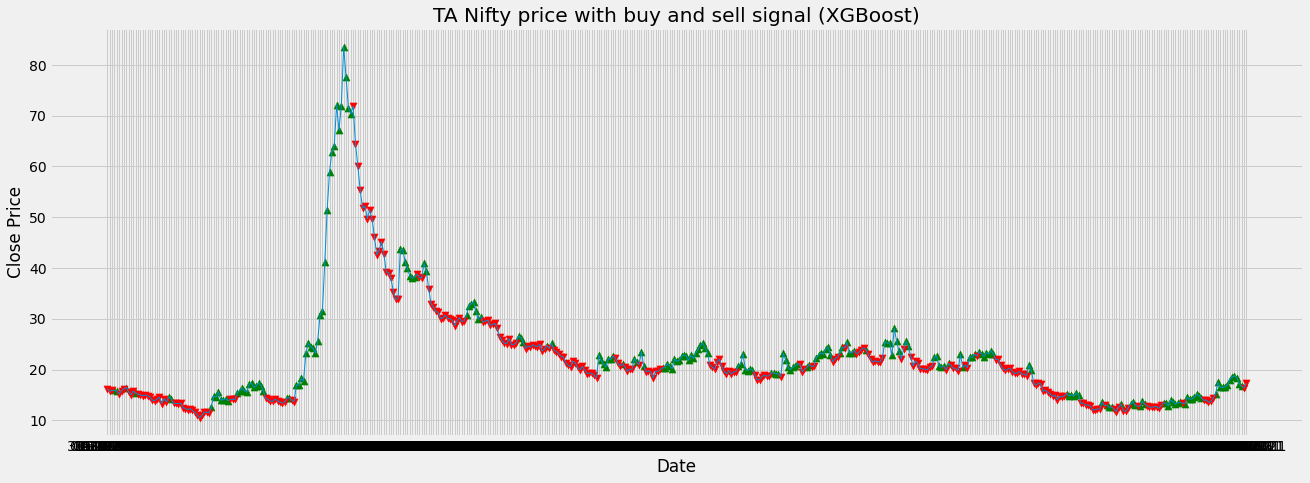

In [90]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

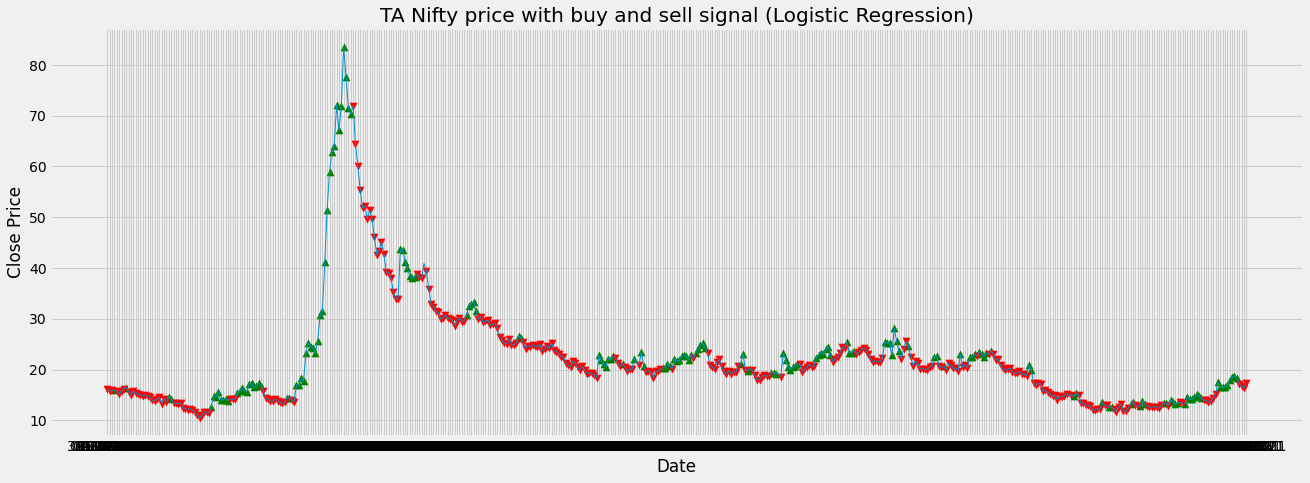

In [91]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

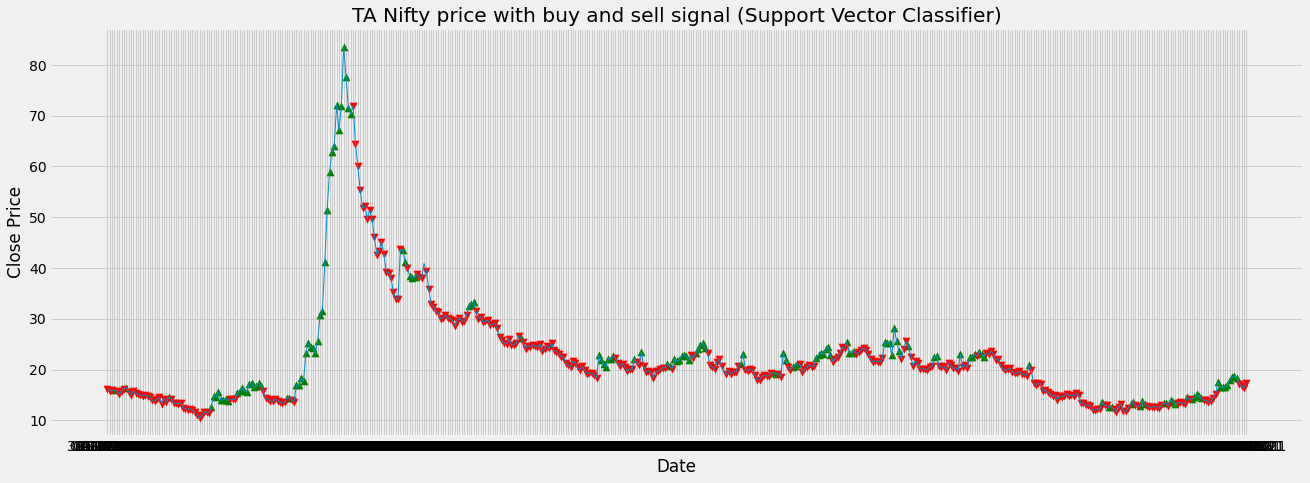

In [92]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [93]:
pred['ensemble'] = pred['predsrandom_forest']*1.0+predL['preds_Logistic_Regression']*0.5+predS['preds_SVC']*0.5 +predX['preds_XGB']*1.0

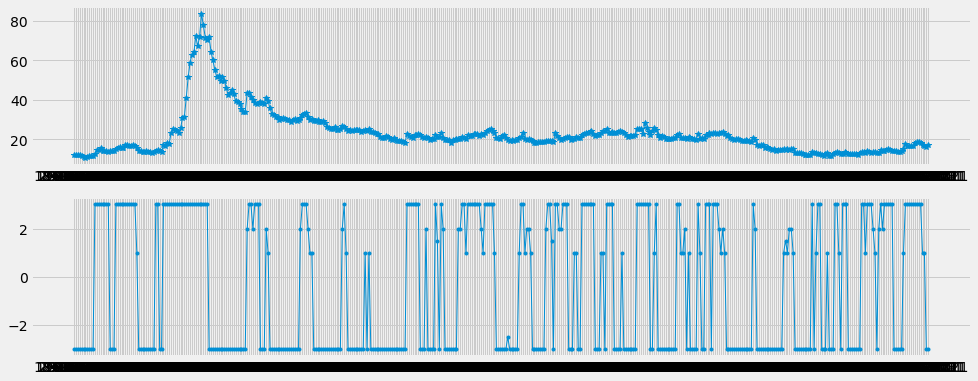

In [94]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [95]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [96]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0), 1, 0)

pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>=0),1,0)

In [97]:
pred['signalF']=pred['signal4theday']

In [98]:
pred.to_csv('rf_ta.csv')

In [99]:
pred[['signal4theday','signalF','Close']].tail(5)

,signal4theday,signalF,Close
478,1,1,18.402500
479,1,1,17.227501
480,1,1,16.730000
481,0,0,16.390000
482,0,0,17.330000


In [100]:
df['EMA_50']=df['Close'].rolling(50).mean()

In [101]:
pred=pred[-l:]

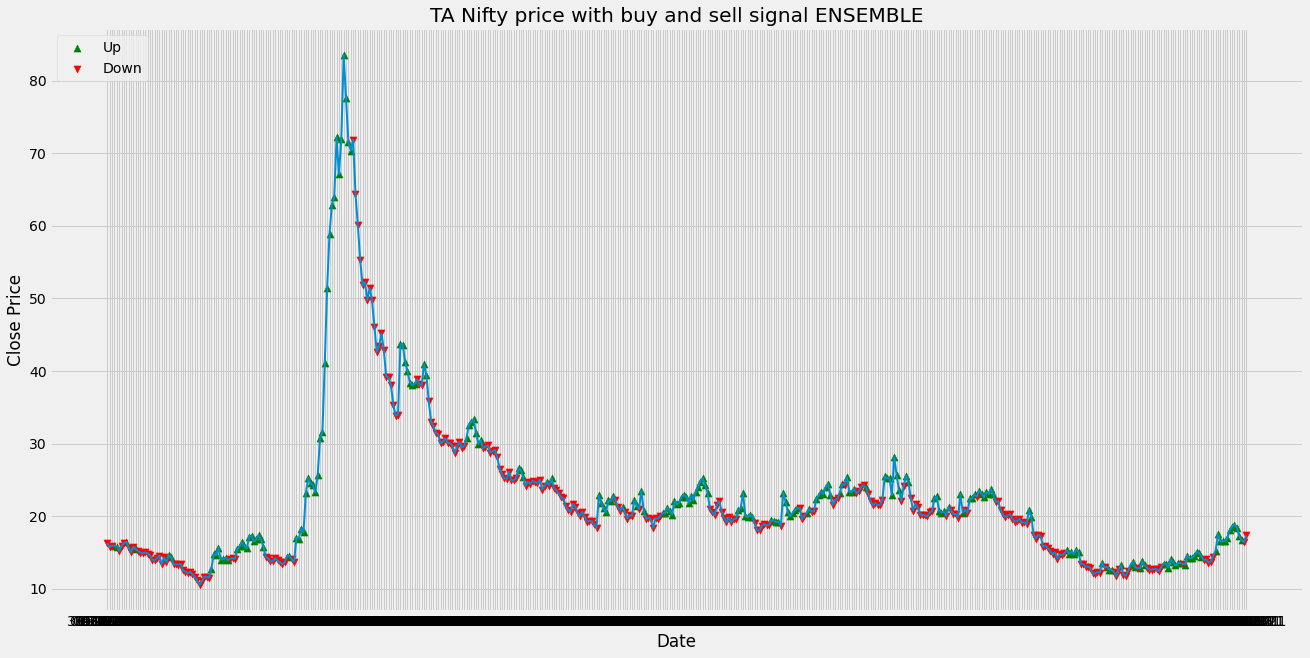

In [102]:
plt.figure(figsize=(20,10))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=50, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
#plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_26'].values[-l:], label='EMA 26')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


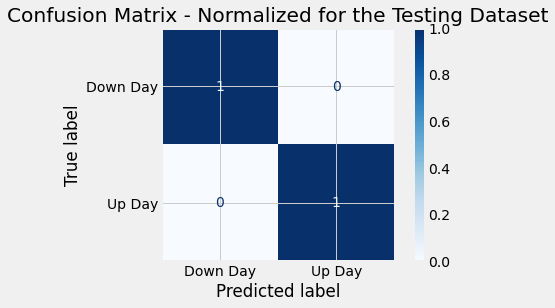

In [103]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 100.0
Percision: 100.0
Recall: 100.0
Specificity: 100.0


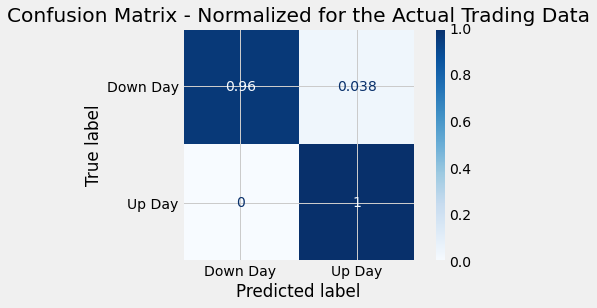

In [104]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [105]:
# saving the dataframe
pred[['Date','signalF']].to_csv('/content/rf_TA.csv')

In [106]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,31-10-2019,-1.0,16.280001,0,0,-3.0,0,0,0,0


In [107]:
pred.set_index('Date',inplace=True)

In [108]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,
05-10-2021,-1.0,16.39,0,0,-3.0,0,0,0,0
06-10-2021,-1.0,17.33,0,0,-3.0,0,0,0,0


In [109]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [110]:
pred.signalF.value_counts()

0    269
1    213
Name: signalF, dtype: int64

In [111]:
pred.dummyS.value_counts()

0.0    269
1.0    213
Name: dummyS, dtype: int64

In [112]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred.actual, pred.dummyS)

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.46265560165975106
Percision: 0.38967136150234744
Recall: 0.3915094339622642
Specificity: 0.5185185185185185
F1-Score: 0.3905882352941177
Average Precision : 0.420194868944873


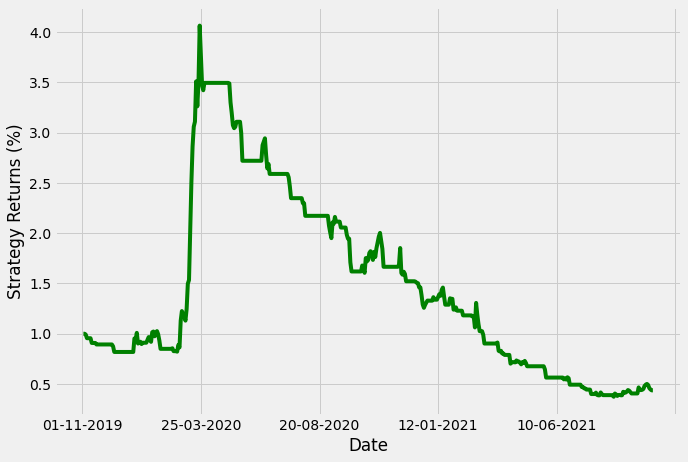

In [113]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

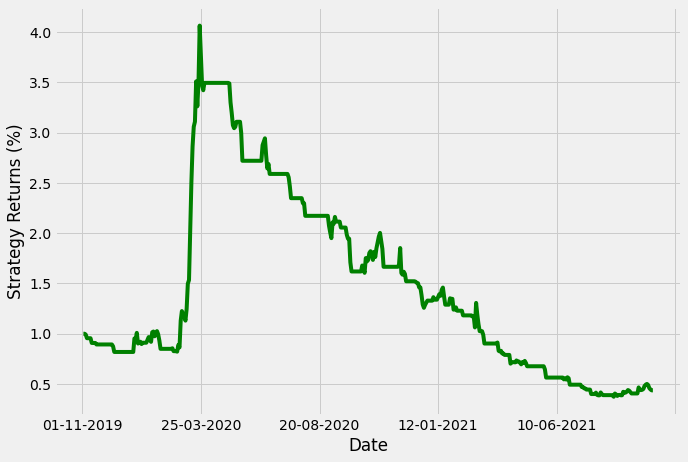

In [114]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_F'] = pred.Return * pred.signalF.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_F+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()